

            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=59509bee28b746cbacbe2d5b9ad57084&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A7777%2Fcallback&scope=playlist-read-private in your browser


Enter the URL you were redirected to: http://localhost:7777/callback?code=AQA93Xqhifq5u34cOO50IawHkN8L4fANxu7wNKIlqnwhF4679tKfrSW5oDUrJDgrfvHOsMdF04viPqP_O4QqngUkxrn54j8M0Cb725N0nEp1sRnOTI7r5uZLcIMBnIIftObaeUub1S-YgGiSwsAXymx1z3aLRK0aVFTT1vu2x1UqBZHaFODOQmSgJAAYfNrjXaZJFveNDlx12NxFKgaV8YD9sNiXCH15aCfA




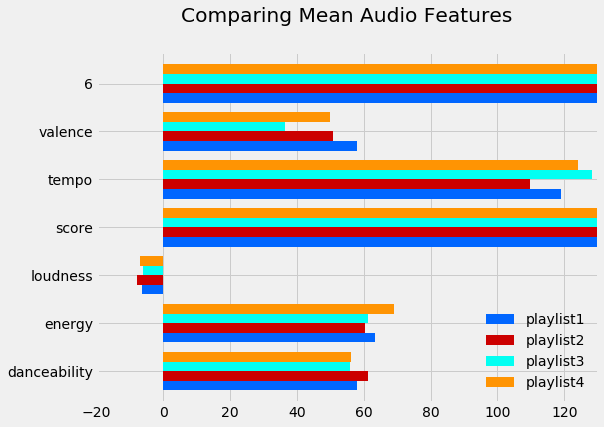

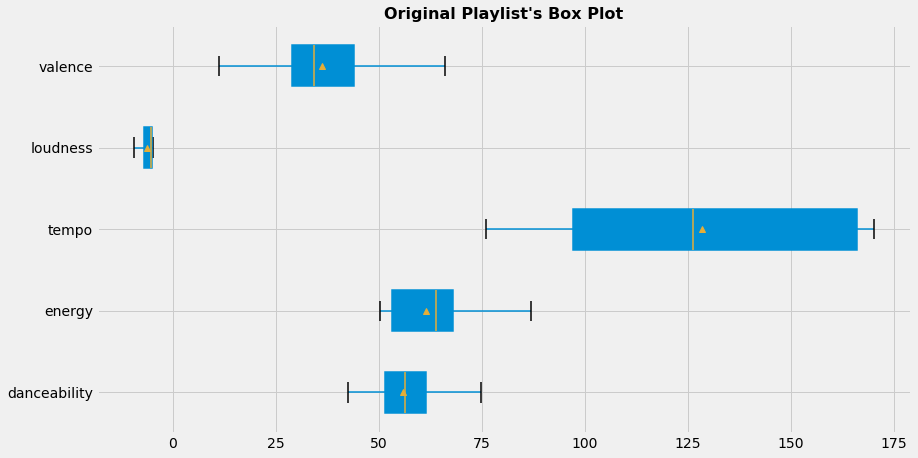



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=59509bee28b746cbacbe2d5b9ad57084&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A7777%2Fcallback&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: http://localhost:7777/callback?code=AQAEyeuk-Vx9a33OGJ9_y4XntTNaBNI9Y95xBbizQujCVtPXzGDtpQDeRBksiHARMjrp8rfyMGPLo3Hu5b9HWLl23VSNLX0VgS4hbeZR9gZF7iGBlHu2omWwKEbchMSQHMID7jX2na6R_gk4rZzP-u3JUE8qjuD4Wm4x6sDhv1fMBhl8i_RpWsSeOwpmIUNPTaWwkHS37E8bT3bNDtu0BRnliKhzjogMk7EeoQ




In [3]:
#importing
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

# Declare the credentials
cid = 'XXXX'
secret = 'XXXX'
redirect_uri='XXXX'
username = 'XXXX'

# Authorization flow
scope = 'playlist-read-private'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

    
#Returns the user's playlists
def fetch_playlists(sp, username):
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

playlists = fetch_playlists(sp,username)
playlists = playlists[:4].copy()


#    Returns the tracks for the given playlist.
def fetch_playlist_tracks(sp, username, playlist_id):
        
    offset = 0
    tracks = []
    
    # Make the API request
    while True:
        content = sp.user_playlist_tracks(username, playlist_id, fields=None, limit=100, offset=offset, market=None)
        tracks += content['items']
        
        if content['next'] is not None:
            offset += 100
        else:
            break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
    # Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

#Returns the selected audio features of every track
def fetch_audio_features(sp, username, playlist_id):
    # Use the fetch_playlist_tracks function to fetch all of the tracks
    playlist = fetch_playlist_tracks(sp, username, playlist_id)
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Append the audio features in a list
    features_list = []
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['energy'], features['tempo'],
                              features['loudness'], features['valence']])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'energy',
                                                             'tempo', 'loudness', 'valence'])

    # Set the 'tempo' & 'loudness' in the same range with the rest features
    for feature in df_audio_features.columns:
        if feature == 'tempo' or feature == 'loudness':
            continue
        df_audio_features[feature] = df_audio_features[feature] * 100
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_id', inplace=True, drop=True)
    
    return df_playlist_audio_features

df_playlists = []
for i, pl in enumerate(playlists.id):
    df_playlists.append(fetch_audio_features(sp, username, pl))
    
for i in range(4):
    df_playlists[i]['score']=df_playlists[i]['danceability']*30+df_playlists[i]['energy']*20+df_playlists[i]['tempo']*20+df_playlists[i]['loudness']*10+df_playlists[i]['valence']*20

#score

score = []
for i in range(4):
    t=(df_playlists[i].mean().danceability * 30) + (df_playlists[i].mean().energy * 20) + (df_playlists[i].mean().tempo * 20) + (df_playlists[i].mean().loudness * 10) + (df_playlists[i].mean().valence * 20)
    score.append(t)

order = (sorted(range(len(score)), key=lambda k: score[k], reverse=True))

p1_mean = pd.DataFrame(df_playlists[0].mean(), columns= ['playlist1'])
p2_mean = pd.DataFrame(df_playlists[1].mean(), columns= ['playlist2'])
p3_mean = pd.DataFrame(df_playlists[2].mean(), columns= ['playlist3'])
p4_mean = pd.DataFrame(df_playlists[3].mean(), columns= ['playlist4'])
all_mean = pd.concat([p1_mean, p2_mean, p3_mean, p4_mean], axis=1, sort=True)


df_length=len(all_mean)
all_mean.loc[df_length] = score

plt.style.use('fivethirtyeight')

all_mean.plot.barh(color = ['#0066FF', '#CC0000', '#03FFF2', '#FF9403'],  width = .8, rot = 0, figsize = (8,6))
plt.title('Comparing Mean Audio Features', y = 1.07)
plt.xlim(-20,130) # because ratings start at 0 and end at 5
plt.legend(framealpha = 0, loc = 'best')
plt.savefig('comparison.png')
#Export here
s1=order[0]
s2=order[1]
s3=order[2]
s4=order[3]

df_plot = df_playlists[2].loc[:, df_playlists[2].columns != 'score']

df_plot.boxplot(vert = False, figsize = (13,7), showfliers = False, showmeans = True, 
                 patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(linestyle='-', linewidth=1.5),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5))

plt.title("Original Playlist's Box Plot", fontsize=16, fontweight='heavy')
plt.savefig('boxplot.png')
#df_playlists[2].describe()
#export here

df_p1=df_playlists[s1]
df_p2=df_playlists[s2]
df_p3=df_playlists[s3]
df_p4=df_playlists[s4]

df_sample_III = df_p2[df_p2['score'] > df_p1['score'].mean()].copy()

df_party_exp_III = pd.concat([df_p1, df_sample_III])
df_party_exp_III.describe()

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)
    
create_playlist(sp, username, 'C&A DJ', 'A pure party playlist created by DJ Pandas!')

final = fetch_playlists(sp,username)

final['id'][0]

def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 100])
        index += 100
        
list_track = df_party_exp_III.index


enrich_playlist(sp, username, final['id'][0], list_track)